In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import kaggle
import datetime
import helper as hp

current_path = os.getcwd()

## Loading

In [3]:
DATASETS = [
    {
        'name': "reddit_wsb.csv",
        'api': "gpreda/reddit-wallstreetsbets-posts",
        'location': "data",
        'url': "https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts"
    },
    {
        'name': "stock_data.csv", # does not have date
        'api': "yash612/stockmarket-sentiment-dataset",
        'location': "data",
        'url': "https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset"
    },
    {
        'name': "stock_tweets.csv",
        'api': "equinxx/stock-tweets-for-sentiment-analysis-and-prediction",
        'location': "data/unorganized/Stock Tweets for Sentiment Analysis and Prediction",
        'url': "https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction?select=stock_tweets"
    },
    {
        'name': "Company_Tweet.csv",
        'api': "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
        'location': "data/unorganized/Tweets about the Top Companies from 2015 to 2020",
        'url': "https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020"
    },
    {
        'name': "Tweet.csv",
        'api': "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
        'location': "data/unorganized/Tweets about the Top Companies from 2015 to 2020",
        'url': "https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020"
    },
    {
        'name': "stockerbot-export.csv", #include news but incorrect time
        'api': "davidwallach/financial-tweets",
        'location': "data/unorganized/Financial Tweets",
        'url': "https://www.kaggle.com/datasets/davidwallach/financial-tweets"
    },
    {
        'name': "tweets_labelled_09042020_16072020.csv",
        'api': "utkarshxy/stock-markettweets-lexicon-data",
        'location': "data/unorganized/Stock Market Tweet",
        'url': "https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data"
    },
    {
        'name': "tweets_remaining_09042020_16072020.csv",
        'api': "utkarshxy/stock-markettweets-lexicon-data",
        'location': "data/unorganized/Stock Market Tweet",
        'url': "https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data"
    }
]

sentiment_data = {}
dataset_names = []
for dataset_info in DATASETS:
    dataset_name = dataset_info['name']
    dataset_location = dataset_info['location']
    file_path = os.path.join(dataset_info['location'], dataset_name)
    if not os.path.exists(file_path):
        print(f"Downloading {dataset_name} from {dataset_info['url']} to {dataset_location}...")
        kaggle.api.dataset_download_files(dataset_info['api'], path=dataset_location, unzip=True)

    print(dataset_name)
    if dataset_name.endswith('.csv'):
        key = dataset_name[:-4]
        if dataset_name in ['tweets_remaining_09042020_16072020.csv']:
            sentiment_data[key] = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip', delimiter=';')
            continue
        sentiment_data[key] = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
    elif dataset_name.endswith('.excel'):
        key = dataset_name[:-6]
        sentiment_data[key] = pd.read_excel(file_path, encoding='utf-8', on_bad_lines='skip')

    dataset_names.append(dataset_name)

reddit_wsb.csv
stock_data.csv
stock_tweets.csv
Company_Tweet.csv
Tweet.csv
stockerbot-export.csv
tweets_labelled_09042020_16072020.csv
tweets_remaining_09042020_16072020.csv


In [4]:
dataset_names

['reddit_wsb.csv',
 'stock_data.csv',
 'stock_tweets.csv',
 'Company_Tweet.csv',
 'Tweet.csv',
 'stockerbot-export.csv',
 'tweets_labelled_09042020_16072020.csv']

## Analysis

In [5]:
stock = 'TSLA'
text_contains = 'TESLA|TSLA'

### Tweets

In [6]:
Company_Tweet = sentiment_data['Company_Tweet'].copy()

Tweet = sentiment_data['Tweet'].copy()
Tweet['post_date'] = Tweet['post_date'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

Tweet_merged = Tweet.merge(Company_Tweet, on='tweet_id', how="left")
print("Number of NA:",sum(Tweet_merged['ticker_symbol'].isna()))

Tweet_merged = Tweet.rename(columns={'post_date': 'date',
                                     'body': 'text',
                                     'ticker_symbol': 'ticker_symbol'
                                     })
Tweet_merged = Tweet_merged.drop(columns=['tweet_id', 'writer', 'comment_num', 'retweet_num', 'like_num'])

Tweet_filtered = Tweet_merged[Tweet_merged['text'].str.contains(text_contains, case=False, na=False)].reset_index(drop=True)
Tweet_filtered['stock'] = stock

Tweet_filtered

Number of NA: 0


,date,text,stock
0,2015-01-01,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,TSLA
1,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,TSLA
2,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,TSLA
3,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,TSLA
4,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,TSLA
...,...,...,...
1123257,2019-12-31,"I'm getting wasted on NYE, and thanks to @NHTS...",TSLA
1123258,2019-12-31,$TSLA Very Interesting dude:,TSLA
1123259,2019-12-31,If only 2020 brought more self-awareness to Te...,TSLA
1123260,2019-12-31,In 2020 I may start Tweeting out positive news...,TSLA


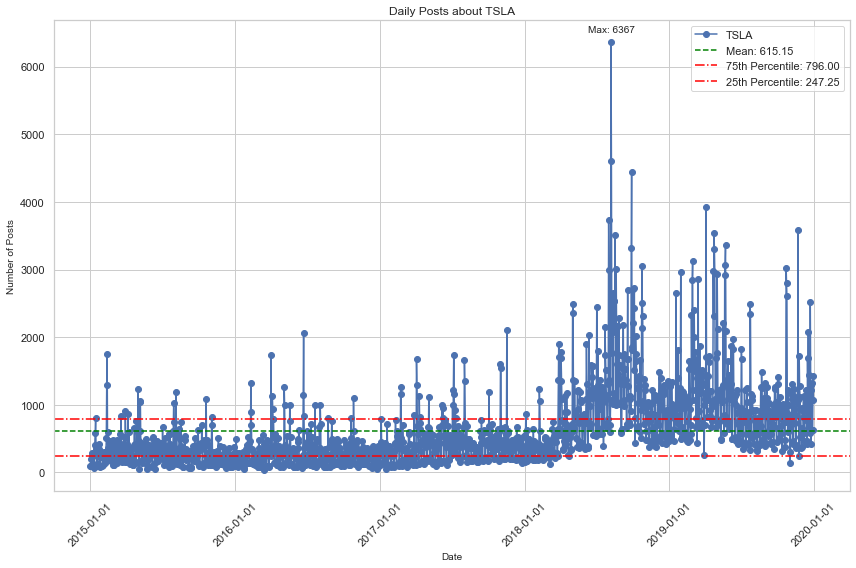

In [7]:
hp.plot_daily_post_counts(Tweet_filtered, stock)

### stock_tweets

In [9]:
stock_tweets = sentiment_data['stock_tweets'].copy()
stock_tweets = stock_tweets.rename(columns={'Date': 'date',
                            'Tweet': 'text',
                            'Stock Name': 'stock'
                            })
stock_tweets = stock_tweets.drop(columns=['Company Name'])
stock_tweets_filtered = stock_tweets[stock_tweets['stock'] == stock]
stock_tweets_filtered

,date,text,stock
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA
...,...,...,...
37417,2021-09-30 02:52:38+00:00,Playing in the dirt and #chasingsunsets\n@tesl...,TSLA
37418,2021-09-30 02:40:26+00:00,I agree with @freshjiva that $TSLA ‘s EV busin...,TSLA
37419,2021-09-30 01:59:02+00:00,Hold. On. Tight. $TSLA,TSLA
37420,2021-09-30 01:38:26+00:00,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...,TSLA


d:\OneDrive\Cornell\Fall 2023\Analyzing-the-Correlation-Between-Retail-Traders--Sentiments-and-Equity-Market-Movements\Unlabeled Data\helper.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


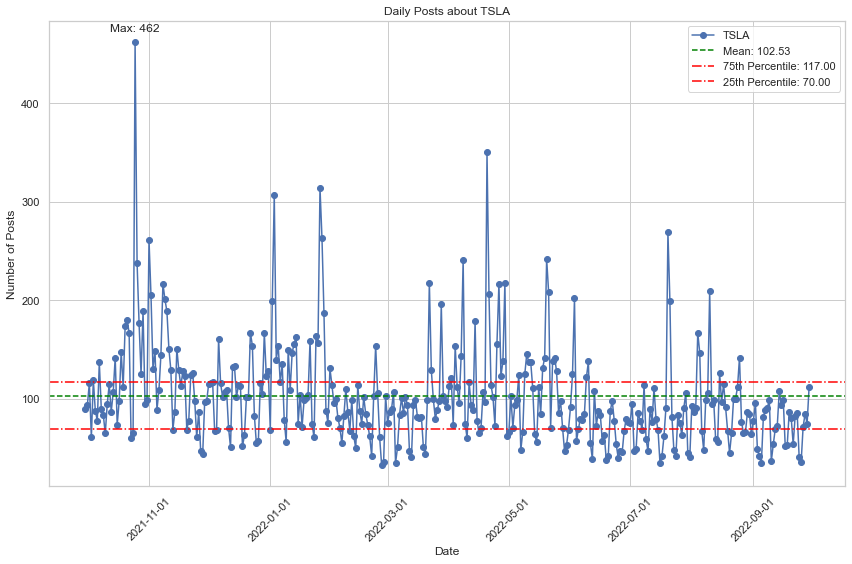

In [13]:
hp.plot_daily_post_counts(stock_tweets_filtered, stock)

### tweets_remaining_09042020_16072020

In [11]:
tweets_remaining = sentiment_data['tweets_remaining_09042020_16072020'].copy()
tweets_remaining = tweets_remaining.rename(columns={'created_at': 'date',
                            'full_text': 'text'
                            })
tweets_remaining = tweets_remaining.drop(columns=['id'])
tweets_remaining_filtered = tweets_remaining[tweets_remaining['text'].str.contains(text_contains, case=False, na=False)].reset_index(drop=True)
tweets_remaining_filtered['stock'] = stock
tweets_remaining_filtered

,date,text,stock
0,2020-04-09 23:56:51+00:00,$UMRX bouncing. EXTREMELY OVERSOLD #Coronaviru...,TSLA
1,2020-04-09 23:48:56+00:00,"Traders, did you secure the 💰 this week? $SPY ...",TSLA
2,2020-04-09 23:37:48+00:00,RT @vieiraUAE: Alex Vieira Tesla is the Next A...,TSLA
3,2020-04-09 23:36:09+00:00,Dow gains 285 points to cap epic rally $AAPL $...,TSLA
4,2020-04-09 23:35:16+00:00,Alex Vieira Tesla is the Next Apple Price Targ...,TSLA
...,...,...,...
60831,2020-07-16 00:06:52+00:00,"About an hour left before the ""Mid-week chart ...",TSLA
60832,2020-07-16 00:05:54+00:00,"Trading Summary - July 15, 2020\n\n7 Trades - ...",TSLA
60833,2020-07-16 00:04:31+00:00,"About an hour left before the ""Mid-week chart ...",TSLA
60834,2020-07-16 00:04:02+00:00,RT @TATrades: Quick poll - how much do you (on...,TSLA


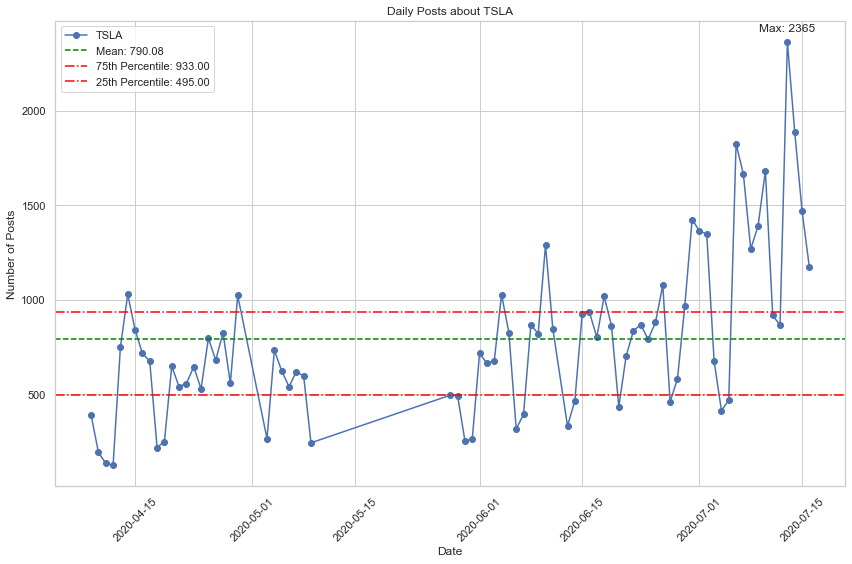

In [14]:
hp.plot_daily_post_counts(tweets_remaining_filtered, stock)